# Running Binary Baysian Logistic Regression on extracted GAP layer

In [1]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import subprocess
import shlex

In [2]:
# to add parent dir to python path
import sys
sys.path.insert(0, '../..')
import multinomial_bayes_logistic as mbl
import vendors.valassis_digital_media.bayes_logistic.bayes_logistic as bl

In [3]:
save_dir = Path("pretrained")

In [4]:
with open(save_dir / 'x_extract.pkl', 'rb') as f_x, open(save_dir / 'y_extract.pkl', 'rb') as f_y:
    # Pickle the 'data' dictionary using the highest protocol available.
    x_extract = pickle.load(f_x)
    y_extract = pickle.load(f_y)

In [5]:
# select two classes
for phase in y_extract:
    class_a = 1
    class_b = 2
    class_ab_idx = ((y_extract[phase] == class_a) | (y_extract[phase] == class_b))
    y_extract[phase] = np.where(y_extract[phase][class_ab_idx] == 1, 1, 0)
    x_extract[phase] = x_extract[phase][class_ab_idx]

In [6]:
# scale inputs
scaler = StandardScaler()
x_extract['train'] = scaler.fit_transform(x_extract['train'])
x_extract['val'] = scaler.transform(x_extract['val'])

In [7]:
for phase in x_extract:
    x_extract[phase] = np.c_[x_extract[phase], np.ones(len(x_extract[phase]))]

In [8]:
# set up prior
m_train = x_extract['train'].shape[0]
n_train = x_extract['train'].shape[1]

w_prior = np.zeros((10, n_train))
H_prior = np.eye(n_train*10) 

In [9]:
n_epoch = 1 # one epoch will do
batch_size = m_train # on all dataset at once

for epoch in range(n_epoch):
    ran_idx = np.random.permutation(np.arange(m_train))
    batch_idx = np.array_split(ran_idx, m_train//batch_size)
    for idx in batch_idx:
        w_prior, H_prior = mbl.fit(
            y_extract['train'][idx], x_extract['train'][idx], w_prior, H_prior, use_autograd=False)

/home/zl430/anaconda3/envs/pt-gpu/lib/python3.7/site-packages/autograd/tracer.py:48: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f_raw(*args, **kwargs)


In [10]:
# get bayes point
val_probs, val_preds, val_max_prob = mbl.get_bayes_point_probs(x_extract['val'], w_prior)
val_correct = np.sum(val_preds == (y_extract["val"]))
val_accuracy = val_correct/len(y_extract['val'])
print("Bayes Point, Epoch: {}, Val Acc: {:.1%}".format(epoch, val_accuracy))

Bayes Point, Epoch: 0, Val Acc: 99.6%


In [11]:
# get monte carlo
mc_val_probs, mc_val_preds, mc_val_max_prob = mbl.get_monte_carlo_probs(x_extract['val'], w_prior, H_prior)
mc_val_correct = np.sum(mc_val_preds == (y_extract["val"]))
mc_val_accuracy = mc_val_correct/len(y_extract['val'])
print("Monte Carlo, Epoch: {}, Val Acc: {:.1%}".format(epoch, mc_val_accuracy))

Monte Carlo, Epoch: 0, Val Acc: 99.6%


In [12]:
mean_increase_in_uncertainty = (np.mean(val_max_prob[val_preds == y_extract["val"]]) 
                                - np.mean(mc_val_max_prob[mc_val_preds == y_extract["val"]]))*100
print("For true positives, increase in uncertainty given by monte carlo over bayes point is {}%".format(mean_increase_in_uncertainty))

For true positives, increase in uncertainty given by monte carlo over bayes point is 0.3857400111149434%


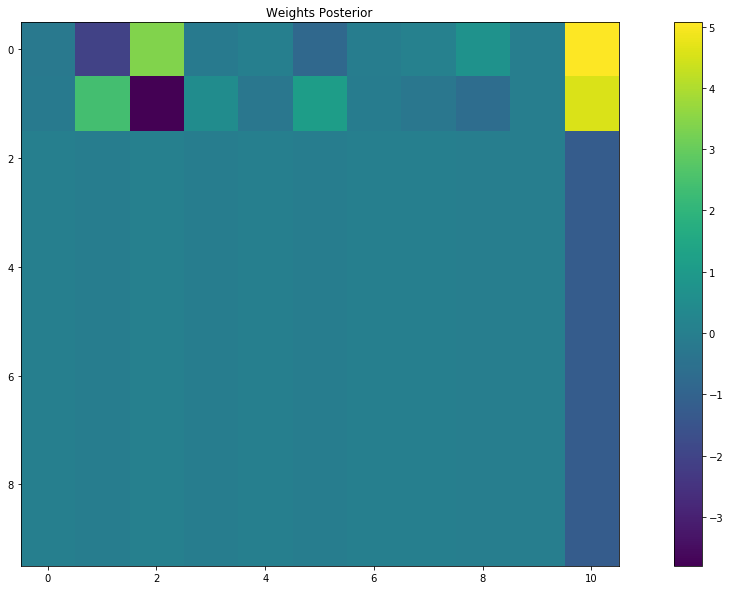

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(w_prior)
plt.title("Weights Posterior")
plt.colorbar()

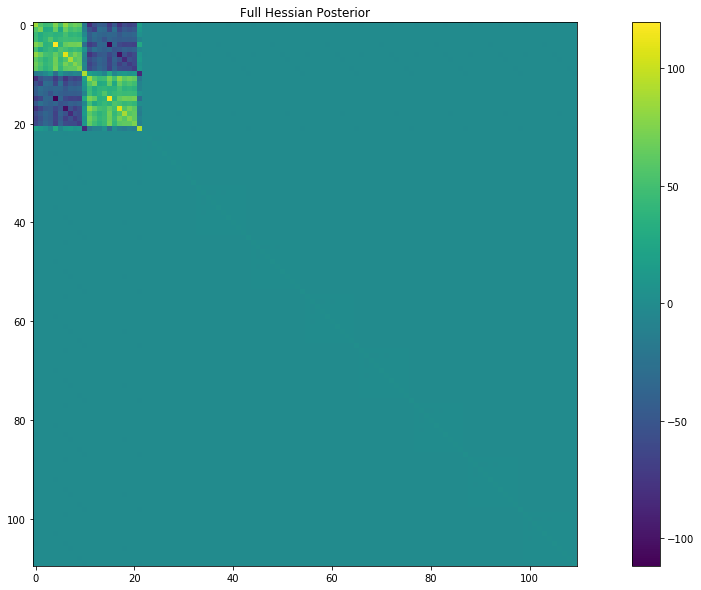

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(H_prior)
plt.title("Full Hessian Posterior")
plt.colorbar()

# Graph the decision boundary

In [15]:
m_train = x_extract['train'].shape[0]
n_train = x_extract['train'].shape[1]

In [16]:
batch_sizes = (100, 500, 1000, m_train)# train using less examples to get the curvature in contour
w_posterior = {}
h_posterior = {}
val_accuracies = {}

# predict using multinomial bayes logistic
    
for batch_size in batch_sizes:
    w_prior = np.zeros((10, n_train))
    H_prior = np.eye(n_train*10) 

    w_prior, H_prior = mbl.fit(
        np.int32(y_extract['train'][:batch_size]), x_extract['train'][:batch_size], w_prior, H_prior, use_autograd=False)
    
    val_probs, val_preds, val_max_prob = mbl.get_bayes_point_probs(x_extract['val'], w_prior)
    val_correct = np.sum(val_preds == (y_extract["val"]))
    val_accuracy = val_correct/len(y_extract['val'])
    
    w_posterior[batch_size] = w_prior
    h_posterior[batch_size] = H_prior
    val_accuracies[batch_size] = val_accuracy

/home/zl430/anaconda3/envs/pt-gpu/lib/python3.7/site-packages/autograd/tracer.py:48: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f_raw(*args, **kwargs)


In [17]:
pca = PCA(n_components = 2)
pca.fit(x_extract['train'])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
V = pca.components_.T

In [19]:
def plot_decision_boundary(batch_sizes, inference):
    plt.figure(figsize=((len(batch_sizes) + 1)* 10, 10))
    
    for phase in ('train', 'val'):
        for col, batch_size in enumerate(batch_sizes):
            if phase == 'val':
                col = len(batch_sizes)
                batch_size = len(x_extract['train'])
            plt.subplot(1, len(batch_sizes) + 1, col + 1)
            
            # plotting the data points
            X = pca.transform(x_extract[phase])
            Y = y_extract[phase]
            
            for digit in range(0, 10):
                plt.scatter(X[Y==digit, 0], X[Y==digit, 1], alpha=0.1, c='0.9')

            X = X[:batch_size]
            Y = Y[:batch_size]
            
            for digit in range(0, 10):
                plt.scatter(X[Y==digit, 0], X[Y==digit, 1], label='Digit {}'.format(digit))

            # plotting the contours  
            min_x = np.min(X[:, 0])
            max_x = np.max(X[:, 0])

            min_y = np.min(X[:, 1])
            max_y = np.max(X[:, 1])

            xx, yy = np.mgrid[min_x - .5 * max_x: max_x + .5 * max_x:50j, min_y - .5 * max_y: max_y + .5 * max_y:50j]
            coords = np.c_[xx.ravel(), yy.ravel()] @ V.T

            if inference == 'monte carlo':
                *_, probs = mbl.get_monte_carlo_probs(coords, w_posterior[batch_size], h_posterior[batch_size])
            elif inference == 'bayes point':
                *_, probs = mbl.get_bayes_point_probs(coords, w_posterior[batch_size])
            zz = probs.reshape(xx.shape)

            contours = plt.contour(xx, yy, zz, 5)
            plt.clabel(contours, fontsize=24)

            plt.legend(loc="upper right", fontsize=24)
            if phase == 'val':
                plt.title('Val dataset', fontsize=28)
            else:
                plt.title("{}, acc {:.1%}, n={}".format(phase.capitalize(), val_accuracies[batch_size], batch_size), fontsize=28)  
            if phase == 'val':
                break
                
    plt.suptitle('Using {} inference'.format(inference), fontsize=32)
    plt.show()

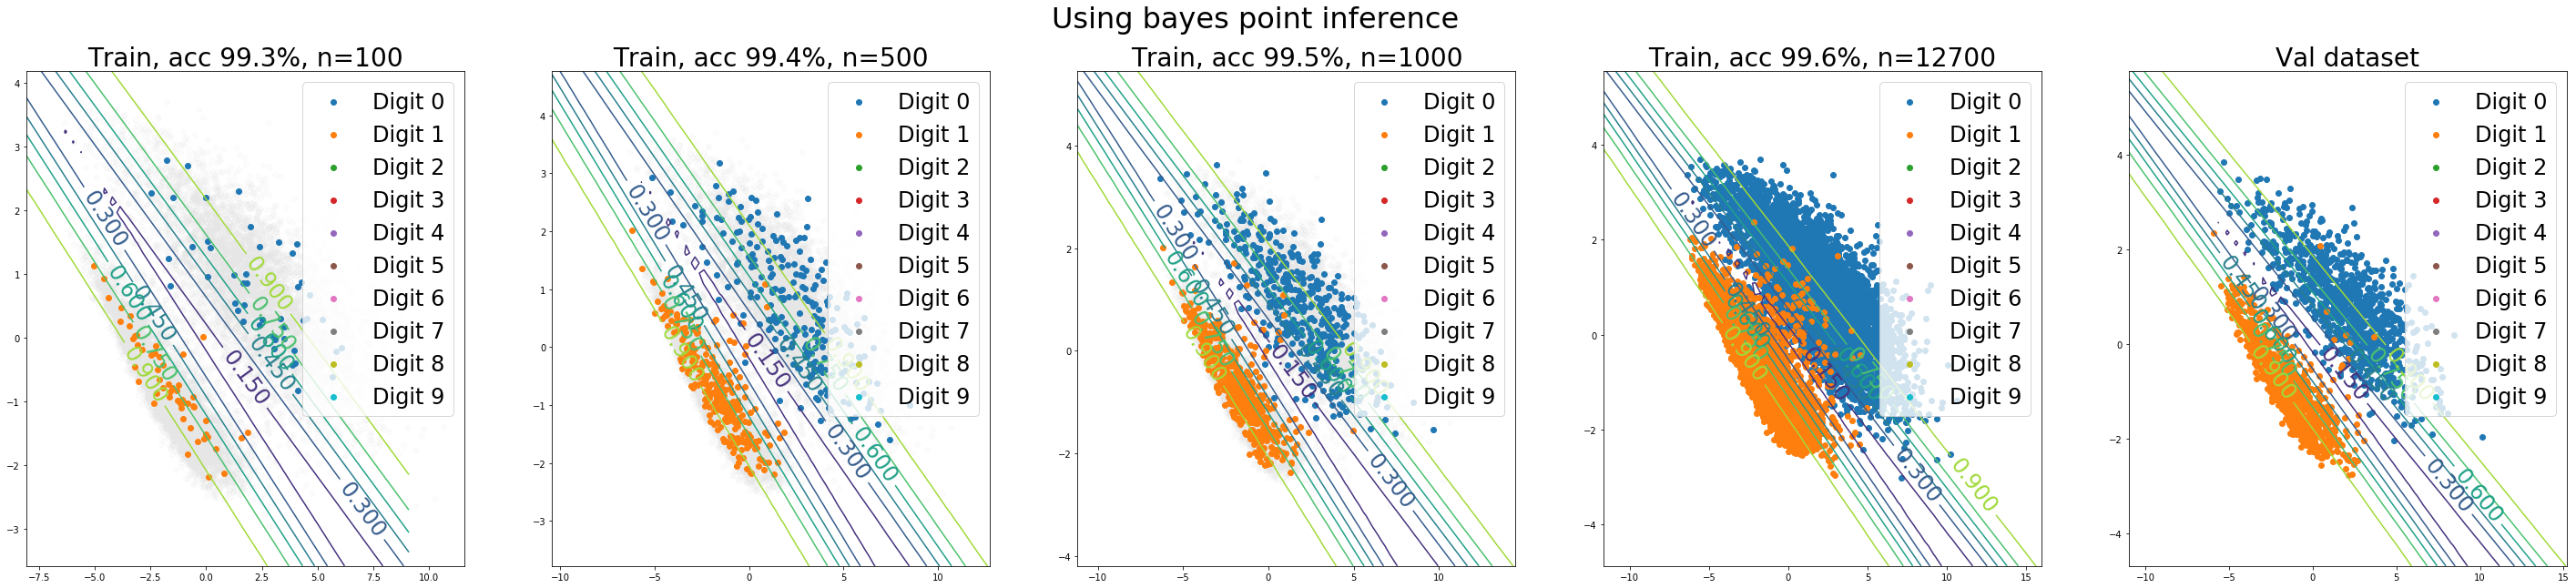

In [20]:
plot_decision_boundary(batch_sizes, 'bayes point')

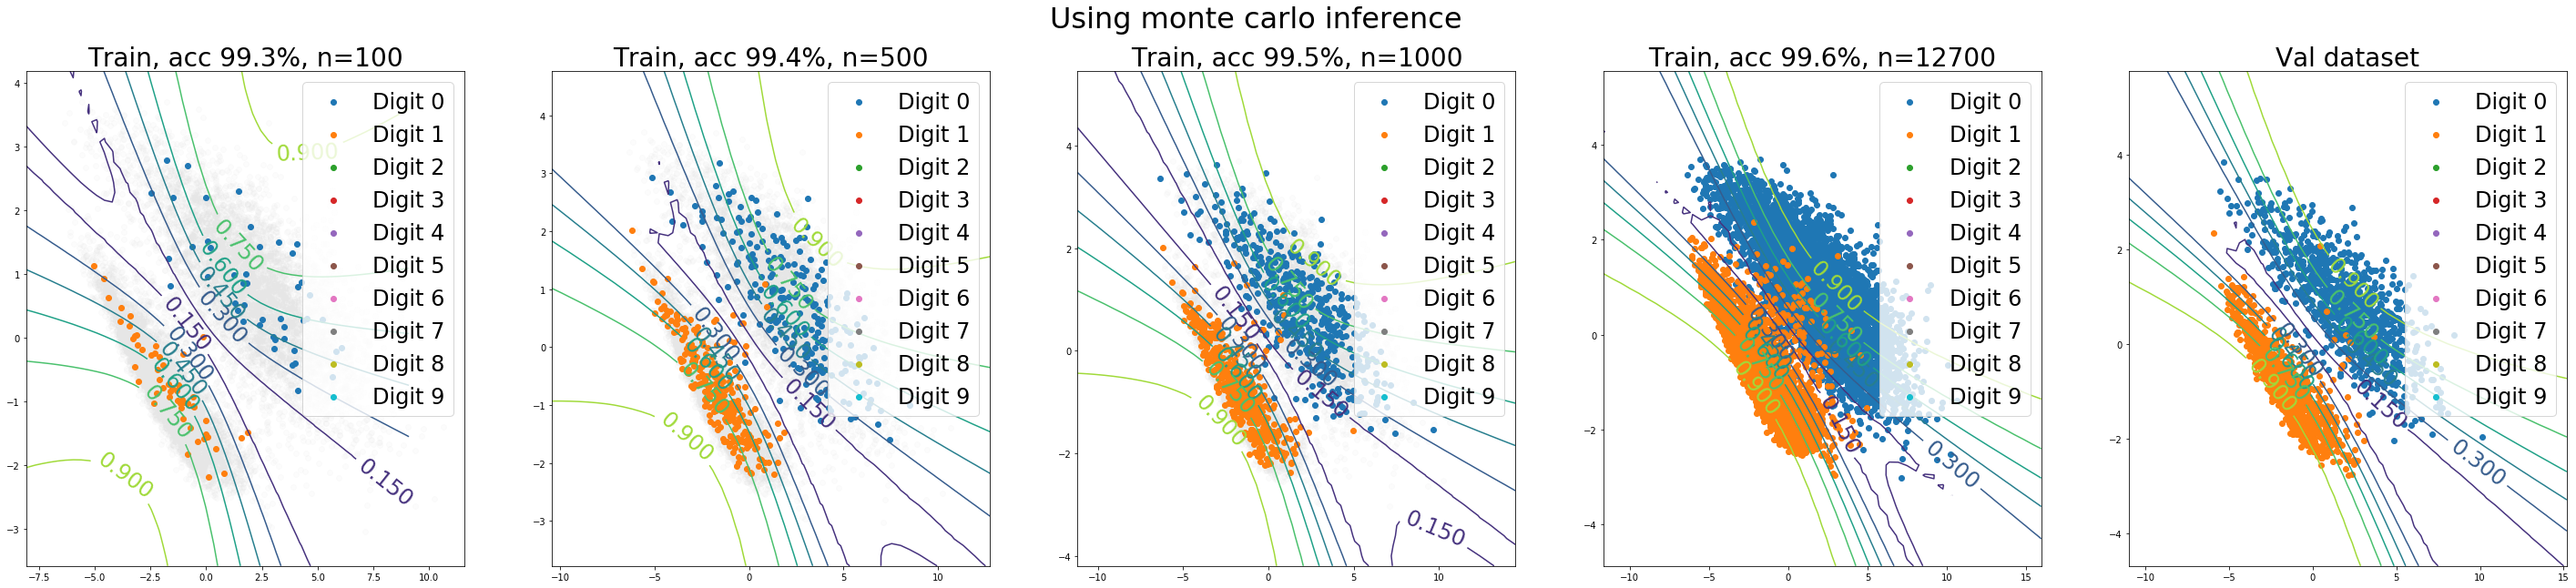

In [21]:
plot_decision_boundary(batch_sizes, 'monte carlo')

# TSNE

In [22]:
x_sne = TSNE().fit_transform(x_extract['train'])

In [23]:
X = x_sne
Y = y_extract['train']

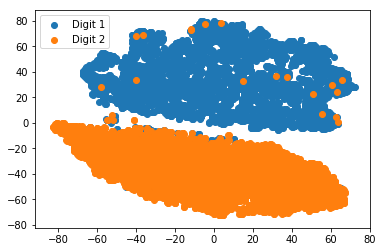

In [24]:
plt.scatter(X[Y==1, 0], X[Y==1, 1], label='Digit {}'.format(class_a))
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Digit {}'.format(class_b))
plt.legend()

# Animation using valassis_digital_media's bayes logistic

In [32]:
save_dir = Path("animations")
os.makedirs(save_dir, exist_ok=True)
ffmpeg_dir = Path('../../vendors/ffmpeg-4.2-amd64-static')

In [33]:
m_train = x_extract['train'].shape[0]
n_train = x_extract['train'].shape[1]

w_prior = np.zeros(n_train)
H_prior = np.diag(np.ones(n_train))

In [34]:
pca = PCA(n_components = 2)
pca.fit(x_extract['train'])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [35]:
X = pca.transform(x_extract['train'])
Y = y_extract['train']

In [36]:
V = pca.components_.T

In [39]:
def make_frame_decision_boundary(end_idx, inference):
    plt.close()
    
    w_posterior, h_posterior = bl.fit_bayes_logistic(
    y_extract['train'][:end_idx], x_extract['train'][:end_idx], w_prior, H_prior)

    # plotting all data points
    plt.scatter(X[Y==1, 0], X[Y==1, 1], alpha=0.1, c='0.9')
    plt.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.1, c='0.9')
    
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    xx, yy = np.mgrid[min_x - 1 * max_x: max_x + 1 * max_x:50j, min_y - 1 * max_y: max_y + 1 * max_y:50j]
    coords = np.c_[xx.ravel(), yy.ravel()]
    
    # and selected datapoints
    plt.scatter(X[:end_idx][Y[:end_idx]==1, 0], X[:end_idx][Y[:end_idx]==1, 1], label='Digit {}'.format(class_a))
    plt.scatter(X[:end_idx][Y[:end_idx]==0, 0], X[:end_idx][Y[:end_idx]==0, 1], label='Digit {}'.format(class_b))

    # plotting the contours  
    w2d = w_posterior @ V
    h2d = V.T @ h_posterior @ V

    if inference == 'probit':
        probs = bl.bayes_logistic_prob(coords, w2d, h2d)
        title = "Bayesian Logistic Regression"
    elif inference == 'bayes_point':
        probs = bl.logistic_prob(coords, w2d)
        title = "Logistic Regression"
    
    zz = probs.reshape(xx.shape)

    contours = plt.contourf(xx, yy, zz, [0.1, 0.5, 0.9], alpha=0.1)
    plt.colorbar()

    plt.legend(loc="upper right", fontsize=12)
    plt.title(title, fontsize=16)
    
    plt.savefig(save_dir/'{:03d}_{}.png'.format(end_idx, inference))

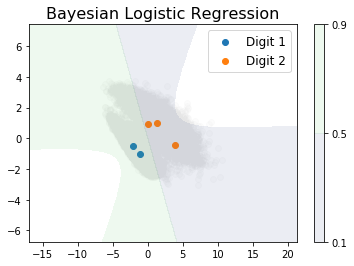

In [40]:
make_frame_decision_boundary(5, 'probit')

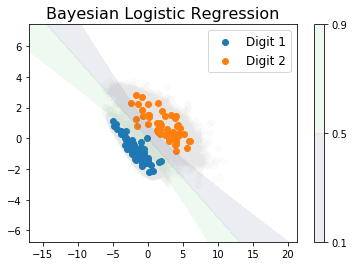

In [41]:
fps = 24
sec = 5
inference = 'probit'
for i in range(sec*fps):
    make_frame_decision_boundary(i, inference)

In [42]:
subprocess.run(
    shlex.split("{0}/ffmpeg -i {1}/%03d_{2}.png {1}/{2}.gif".format(ffmpeg_dir, save_dir, inference)))

CompletedProcess(args=['../../vendors/ffmpeg-4.2-amd64-static/ffmpeg', '-i', 'animations/%03d_probit.png', 'animations/probit.gif'], returncode=0)

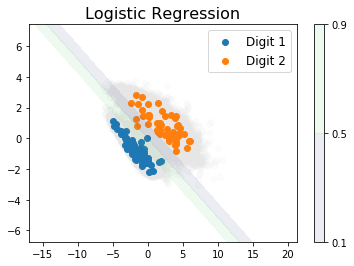

In [43]:
inference = 'bayes_point'
for i in range(sec*fps):
    make_frame_decision_boundary(i, inference)

In [44]:
subprocess.run(
    shlex.split("{0}/ffmpeg -i {1}/%03d_{2}.png {1}/{2}.gif".format(ffmpeg_dir, save_dir, inference)))

CompletedProcess(args=['../../vendors/ffmpeg-4.2-amd64-static/ffmpeg', '-i', 'animations/%03d_bayes_point.png', 'animations/bayes_point.gif'], returncode=0)